# An Analysis of NBA College Drafts

**Original Project Specifications Provided by Professor Chris Teplovs

## Objective
Using data from two sources (Wikipedia and basketball-reference.com), we attempt to understand patterns in the types of players who get drafted to the NBA.

## Background

In a draft, National Basketball Association (NBA) teams took turns selecting amateur U.S. college basketball players and other eligible players, including international players. (https://en.wikipedia.org/wiki/2011_NBA_draft) 

A draft is a process used in some countries and sports to allocate certain players to teams. In a draft, teams take turns selecting from a pool of eligible players. When a team selects a player, the team receives exclusive rights to sign that player to a contract, and no other team in the league may sign the player.
The best-known type of draft is the entry draft, which is used to allocate players who have recently become eligible to play in a league. Depending on the sport, the players may come from college, high school or junior teams or teams in other countries.

An entry draft is intended to prevent expensive bidding wars for young talent and to ensure that no one team can sign contracts with all of the best young players and make the league uncompetitive. To encourage parity, teams that do poorly in the previous season usually get to choose first in the postseason draft, sometimes with a "lottery" factor to discourage teams from deliberately losing.
(https://en.wikipedia.org/wiki/Draft_(sports))

## Data Sources 

We used two sources of data for this analysis:  Basketball Reference (www.basketball-reference.com) and Wikipedia. Basketball Reference was provided in the form of CSV files. Additional player data was scraped from Wikipedia. For this analysis we used 10 years of data (from 2008 to 2017).

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

## Reading the CSV files

Each of the CSV files follow the same format.  There are two header lines and 60 data lines.  The first 30 data lines 
represent players from the first round of drafts and the last 30 data lines represent players from the 
second round of drafts.

In [70]:
filenames = ['NBA_2008.csv', 'NBA_2009.csv', 'NBA_2010.csv', 'NBA_2011.csv', 'NBA_2012.csv', 'NBA_2013.csv', 'NBA_2014.csv', 'NBA_2015.csv', 'NBA_2016.csv', 'NBA_2017.csv']
filenames_with_year_draft = []
year = 2008

#adding year and round columns
for file in filenames:
    df = pd.read_csv(file)
    df['Year'] = year
    df['Round'] = ""
    df['Round'][:31] = 1
    df['Round'][30:] = 2
    
    filenames_with_year_draft.append(df)
    year += 1

#concat all the files together
combined_csv = pd.concat(filenames_with_year_draft)


#cleaning up the players column

splits = combined_csv['Player'].str.split("\\")
combined_csv['Player'] = splits.str[0]


combined_csv.head(10)


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,...,MP.1,PTS.1,TRB.1,AST.1,WS,WS/48,BPM,VORP,Year,Round
0,1,1,CHI,Derrick Rose,University of Memphis,9.0,486.0,16600.0,9312.0,1764.0,...,34.2,19.2,3.6,5.8,34.3,0.099,0.4,10.2,2008,1
1,2,2,MIA,Michael Beasley,Kansas State University,10.0,561.0,13052.0,7082.0,2669.0,...,23.3,12.6,4.8,1.3,14.6,0.054,-3.3,-4.3,2008,1
2,3,3,MIN,O.J. Mayo,University of Southern California,8.0,547.0,16919.0,7574.0,1706.0,...,30.9,13.8,3.1,2.9,21.8,0.062,-0.8,5.1,2008,1
3,4,4,SEA,Russell Westbrook,University of California Los Angeles,10.0,725.0,24848.0,16605.0,4683.0,...,34.3,22.9,6.5,8.1,87.5,0.169,6.6,54.0,2008,1
4,5,5,MEM,Kevin Love,University of California Los Angeles,10.0,624.0,20116.0,11450.0,7061.0,...,32.2,18.3,11.3,2.3,75.8,0.181,2.8,24.5,2008,1
5,6,6,NYK,Danilo Gallinari,NaN,9.0,478.0,14904.0,7341.0,2241.0,...,31.2,15.4,4.7,2.0,42.3,0.136,1.0,11.2,2008,1
6,7,7,LAC,Eric Gordon,Indiana University,10.0,543.0,18095.0,9092.0,1369.0,...,33.3,16.7,2.5,3.1,29.4,0.078,-0.7,5.7,2008,1
7,8,8,MIL,Joe Alexander,West Virginia University,2.0,67.0,745.0,282.0,120.0,...,11.1,4.2,1.8,0.7,0.5,0.030,-3.3,-0.2,2008,1
8,9,9,CHA,D.J. Augustin,University of Texas at Austin,10.0,701.0,16441.0,6660.0,1250.0,...,23.5,9.5,1.8,3.8,33.2,0.097,-1.7,1.4,2008,1
9,10,10,NJN,Brook Lopez,Stanford University,10.0,611.0,19165.0,11021.0,4193.0,...,31.4,18.0,6.9,1.5,51.1,0.128,0.8,13.6,2008,1


## Scraping data from Wikipedia tables

In [71]:
headerLine = 0 
tableNumber = 3

In [74]:
df_wiki = pd.DataFrame()
urls = ['https://en.wikipedia.org/wiki/2017_NBA_draft',
        'https://en.wikipedia.org/wiki/2016_NBA_draft', 
        'https://en.wikipedia.org/wiki/2015_NBA_draft', 
        'https://en.wikipedia.org/wiki/2014_NBA_draft', 
        'https://en.wikipedia.org/wiki/2013_NBA_draft', 
        'https://en.wikipedia.org/wiki/2012_NBA_draft', 
        'https://en.wikipedia.org/wiki/2011_NBA_draft', 
        'https://en.wikipedia.org/wiki/2010_NBA_draft', 
        'https://en.wikipedia.org/wiki/2009_NBA_draft', 
        'https://en.wikipedia.org/wiki/2008_NBA_draft']

for url in urls:
    dx = pd.read_html(url, header=headerLine)[tableNumber]
    df_wiki = pd.concat([df_wiki, dx]).reset_index(drop=True)
df_wiki.head(10)

,Nationality[n 1],Pick,Player,Pos.,Position,Rnd.,Round,School / club team,School/club team,Team
0,United States,1,"Fultz, MarkelleMarkelle Fultz",PG/SG,NaN,1.0,NaN,Washington (Fr.),NaN,Philadelphia 76ers (from Brooklyn via Boston)[...
1,United States,2,"Ball, LonzoLonzo Ball",PG,NaN,1.0,NaN,UCLA (Fr.),NaN,Los Angeles Lakers
2,United States,3,"Tatum, JaysonJayson Tatum",SF,NaN,1.0,NaN,Duke (Fr.),NaN,Boston Celtics (from Sacramento via Philadelph...
3,United States,4,"Jackson, JoshJosh Jackson",SF,NaN,1.0,NaN,Kansas (Fr.),NaN,Phoenix Suns
4,United States,5,"Fox, De'AaronDe'Aaron Fox",PG,NaN,1.0,NaN,Kentucky (Fr.),NaN,Sacramento Kings (from Philadelphia)[C]
5,United States,6,"Isaac, JonathanJonathan Isaac",SF/PF,NaN,1.0,NaN,Florida State (Fr.),NaN,Orlando Magic
6,Finland,7,"Markkanen, LauriLauri Markkanen",PF,NaN,1.0,NaN,Arizona (Fr.),NaN,Minnesota Timberwolves (traded to Chicago Bull...
7,France[n 2],8,"Ntilikina, FrankFrank Ntilikina",PG,NaN,1.0,NaN,SIG Strasbourg (France),NaN,New York Knicks
8,United States,9,"Smith Jr., DennisDennis Smith Jr.",PG,NaN,1.0,NaN,NC State (Fr.),NaN,Dallas Mavericks
9,United States,10,"Collins, ZachZach Collins",C/PF,NaN,1.0,NaN,Gonzaga (Fr.),NaN,"Sacramento Kings (from New Orleans,[D] traded ..."


### Cleaning Wiki tables


In [75]:
#Removing duplicate columns and inconsistencies with the data

df_wiki['Position'].fillna(df_wiki['Pos.'], inplace = True) #filling in Pos. data to Position and dropping the Pos. columns
del df_wiki['Pos.']

df_wiki['Round'].fillna(df_wiki['Rnd.'], inplace = True) #doing it again for Round
del df_wiki['Rnd.']

df_wiki['School/club team'].fillna(df_wiki['School / club team'], inplace = True) #doing it one more time to clean School/club team
del df_wiki['School / club team']
df_wiki.head(10)


,Nationality[n 1],Pick,Player,Position,Round,School/club team,Team
0,United States,1,"Fultz, MarkelleMarkelle Fultz",PG/SG,1.0,Washington (Fr.),Philadelphia 76ers (from Brooklyn via Boston)[...
1,United States,2,"Ball, LonzoLonzo Ball",PG,1.0,UCLA (Fr.),Los Angeles Lakers
2,United States,3,"Tatum, JaysonJayson Tatum",SF,1.0,Duke (Fr.),Boston Celtics (from Sacramento via Philadelph...
3,United States,4,"Jackson, JoshJosh Jackson",SF,1.0,Kansas (Fr.),Phoenix Suns
4,United States,5,"Fox, De'AaronDe'Aaron Fox",PG,1.0,Kentucky (Fr.),Sacramento Kings (from Philadelphia)[C]
5,United States,6,"Isaac, JonathanJonathan Isaac",SF/PF,1.0,Florida State (Fr.),Orlando Magic
6,Finland,7,"Markkanen, LauriLauri Markkanen",PF,1.0,Arizona (Fr.),Minnesota Timberwolves (traded to Chicago Bull...
7,France[n 2],8,"Ntilikina, FrankFrank Ntilikina",PG,1.0,SIG Strasbourg (France),New York Knicks
8,United States,9,"Smith Jr., DennisDennis Smith Jr.",PG,1.0,NC State (Fr.),Dallas Mavericks
9,United States,10,"Collins, ZachZach Collins",C/PF,1.0,Gonzaga (Fr.),"Sacramento Kings (from New Orleans,[D] traded ..."


In [76]:
df_wiki.columns = ['Nationality', 'Pick', 'Player', 'Position', 'Round', 'From','Team']

#df_wiki.head(10)

In [77]:
#Formatting Player name column
name = df_wiki["Player"].str.split(" ")
columns = list(name)
players_cleaned = []
for listy in columns:
    player = listy[int((len(listy)/2) - .5)][int(len(listy[int((len(listy)/2) - .5)])/2):] #accounts for every edge case where some players might have middle names
    for i in listy[int((len(listy)/2) - .5)+1:]:
        player = player + " " + i
    players_cleaned.append(player)

df_wiki['Player'] = players_cleaned
df_wiki.head(10)



,Nationality,Pick,Player,Position,Round,From,Team
0,United States,1,Markelle Fultz,PG/SG,1.0,Washington (Fr.),Philadelphia 76ers (from Brooklyn via Boston)[...
1,United States,2,Lonzo Ball,PG,1.0,UCLA (Fr.),Los Angeles Lakers
2,United States,3,Jayson Tatum,SF,1.0,Duke (Fr.),Boston Celtics (from Sacramento via Philadelph...
3,United States,4,Josh Jackson,SF,1.0,Kansas (Fr.),Phoenix Suns
4,United States,5,De'Aaron Fox,PG,1.0,Kentucky (Fr.),Sacramento Kings (from Philadelphia)[C]
5,United States,6,Jonathan Isaac,SF/PF,1.0,Florida State (Fr.),Orlando Magic
6,Finland,7,Lauri Markkanen,PF,1.0,Arizona (Fr.),Minnesota Timberwolves (traded to Chicago Bull...
7,France[n 2],8,Frank Ntilikina,PG,1.0,SIG Strasbourg (France),New York Knicks
8,United States,9,Dennis Smith Jr.,PG,1.0,NC State (Fr.),Dallas Mavericks
9,United States,10,Zach Collins,C/PF,1.0,Gonzaga (Fr.),"Sacramento Kings (from New Orleans,[D] traded ..."


## What proportion of Round 1 draft picks identify their nationality as something other than U.S.A?

For this analysis, if a player identifies with multiple nationalities, we count them as identifying as something other than USA. According to our data, it appears that 28% of round one draft picks identify their nationality as something other than USA. This is interesting given that basketball has been increasing in popularity amongst other countries over the years. Now, more than a quarter of the top players at the collegiate level come from another country. 

## Aside from nationalities of “U.S.A”, what are the other most common nationalities of Round 1 draft picks?

It appears to be that the top ten countries that are represented in round one draft picks are Canada, France, Spain, Croatia, Brazil, Serbia, Lithuania, Australia, Greece, and Cameroon. A majority of these nations are in Europe, which could indicate strengthening popularity in that region.


In [78]:
#subsetting our round 1 drafts
nationalities = df_wiki[df_wiki.Round == 1.0]
firstrounders = len(nationalities)
non_US = 0
for country in nationalities["Nationality"]:
    if country != "United States":
        non_US += 1

print("{}% of Round 1 draft picks identify their nationality as something other than USA".format((non_US/firstrounders)*100))


#sorting to get the top 10 most common nationalities
nationalities['Nationality'].value_counts()[1:11]

28.000000000000004% of Round 1 draft picks identify their nationality as something other than USA


Canada       10
France        9
Spain         3
Croatia       3
Brazil        3
Serbia        3
Lithuania     2
Australia     2
Greece        2
Cameroon      2
Name: Nationality, dtype: int64

## Which universities are top feeders for the NBA Round 1 draft?

According to this analysis, Kentucky, Duke, UCLA, and Kansas are the top four schools that feed freshmen players into the NBA through the first round draft. If top high school prospects are looking for long term careers in the sport, it may be best to consider these schools. 

In [79]:
#sorting to get the top 10 most common schools round 1 drafts come from
nationalities['From'].value_counts().head(10)

Kentucky (Fr.)          20
Duke (Fr.)               9
UCLA (Fr.)               7
Kansas (Fr.)             6
Syracuse (So.)           5
Kansas (Jr.)             5
Texas (Fr.)              5
North Carolina (Jr.)     5
Arizona (Fr.)            4
Syracuse (Fr.)           4
Name: From, dtype: int64

## How successful were their careers in the NBA?

After scraping at additional data provided on the Wikipedia site, we were able to generalize the outcome of players' careers. For this analysis, we assumed that if a player participated in at least one All-Star Game, or at least one All-NBA Team, or both, then they had a highly successful career. If a player never played in the NBA regular season or playoffs, their success level was considered low. Everyone else fell somewhere in between with moderate success.

Figure 1 below shows the distribution of average game stats for each category. It appears that players who were first round draft picks that ended up having moderately successful careers have the largest spread for points per game. We have "medium" leveled players that average 0 points per game while others who score 25 and above. However, it is clear that points per game, in combination of assists and rebounds contirbutes to how valuable a player is to a team. For those who do not score as much, they make up for it in these other areas. 

Similar trends can be seen with lower performing players. However, players in this bracket score a max of 8 points per game, 4 rebounds, and 2 assists on average. 

Figure 2 shows players' career game stats by nationality. Overall, it appears that US players have had the most successful careers when it comes to minutes, points, rebounds, assists, and value over replacement player. There are also a few outliers from Australia, Latvia, and Canada that seem to have performed quite well. 

In [85]:
#for the "x" outcomes getting the color from wiki
#Note that we only need to do this for the names ending with the 'x' since the other names would not otherwise end with a +, # or *
color = []
list_objects = []
for url in urls:
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    x = soup.findAll("td", {"bgcolor": "#CCFFCC"})
    list_objects.append(x)



some_set = list_objects[4]    #subsetting since the rest are 'None' values

for each in some_set[1:]:
    text = each.find("a")['title']
    color.append(text)


df_wiki['outcome'] = 'medium'
df_wiki["outcome"] = np.where(df_wiki["Player"].isin(color), "high", df_wiki['outcome'])


df_wiki['outcome'] = pd.np.where(df_wiki.Player.str.contains("#"), "low", pd.np.where(df_wiki.Player.str.contains("\*"), "high", pd.np.where(df_wiki.Player.str.contains("\+"), "high", "medium")))



In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

### Figure 1: Average Game Stats by Career Outcome

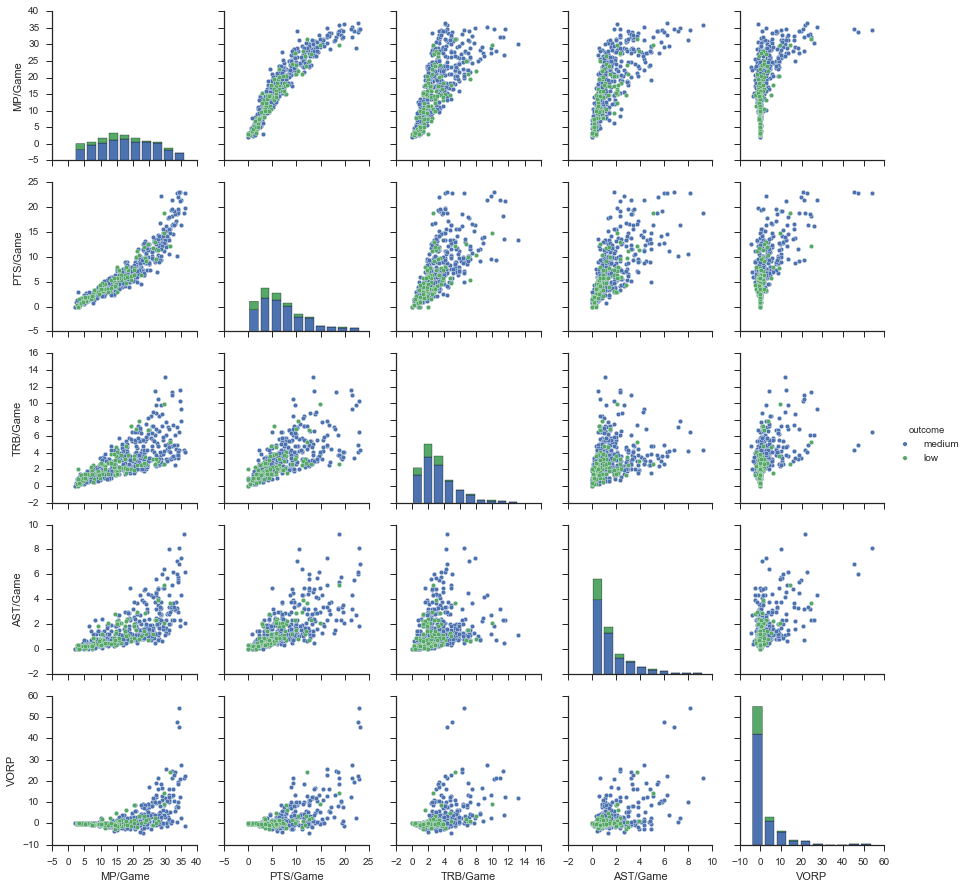

In [88]:
#renaming some columns
combined_csv.rename(columns = {'MP.1' : "MP/Game", 'PTS.1' : "PTS/Game", 'TRB.1' :"TRB/Game", 'AST.1' : "AST/Game"}, inplace = True)


#Starting by joining the tables together
df_wiki.set_index('Player')
df_wiki.set_index('outcome')
combined_csv.set_index('Player')
df_joined = df_wiki.join(combined_csv,rsuffix='_r')

df_joined.set_index('outcome')

sns.pairplot(df_joined[['MP/Game', 'PTS/Game', 'TRB/Game', 'AST/Game', 'VORP', 'outcome']].dropna(), hue = 'outcome')


### Figure 2: Career Game Stats by Nationality

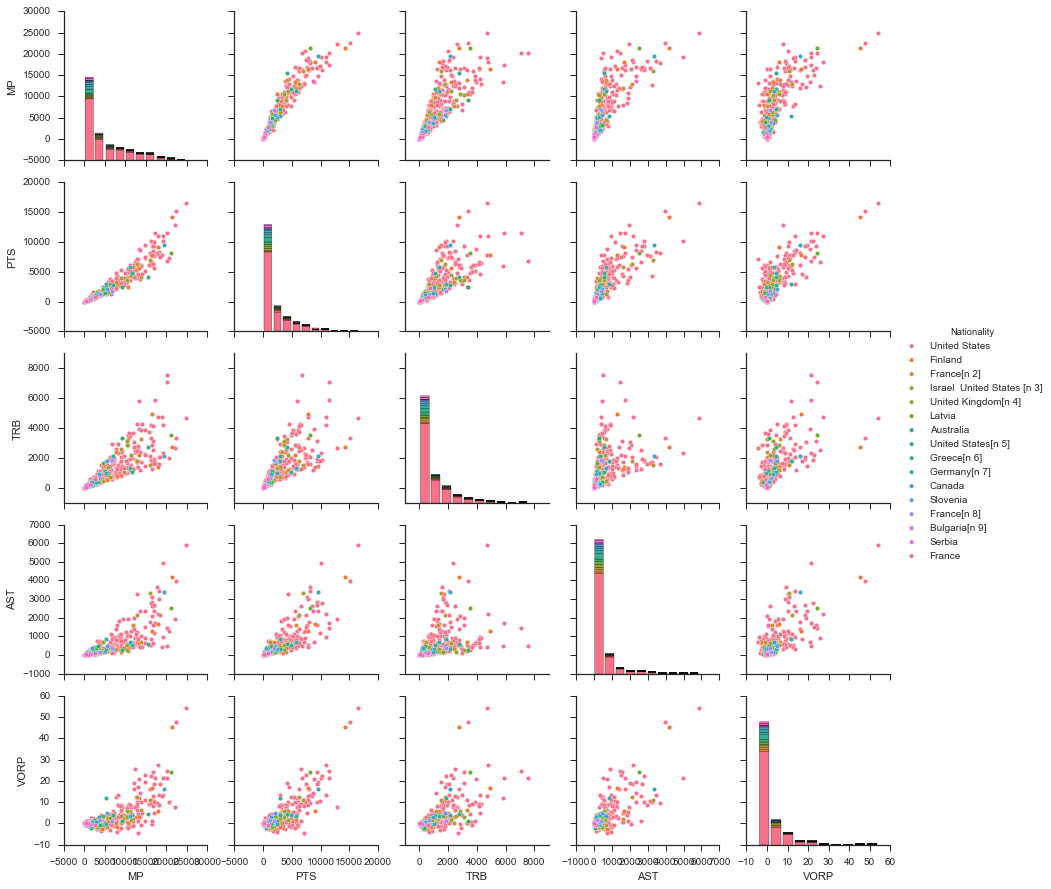

In [90]:
#total number of minutes, points, rebounds, assists paired since the mean can be pulled towards skewed data
sns.pairplot(df_joined[['MP', 'PTS', 'TRB', 'AST', 'VORP', 'Nationality']].dropna(), hue = 'Nationality')

## Which teams are getting the most players through the draft?

Typically, teams that do not do well in the previous season get to pick first. These teams may not have been doing so well over the years...Or they could be doing extremely well and attracting top talent. It appears that the top five teams to get players through the are the 76ers, Spurs, Pistons, Suns, and Bulls. It seems like a mix given the Spurs have performed well in the past few years. 

In [21]:
#Getting the top 10 teams that round 1 picks got drafted to over the years
nationalities['Team'].value_counts()[:10]  

Philadelphia 76ers       9
San Antonio Spurs        8
Detroit Pistons          8
Phoenix Suns             8
Chicago Bulls            7
Golden State Warriors    7
Milwaukee Bucks          7
Sacramento Kings         7
Orlando Magic            7
New York Knicks          6
Name: Team, dtype: int64

## Conclusion:

Overall, it appears that basketball is growing in popularity internationally. Top collegiate players come from all over and a majority of round one picks tend to have moderately successful careers at the professional level. We identified some schools that are top feeder programs as well as NBA teams that have showed quite a bit of interest in new, young talent. An additional analysis that would be interesting to explore would be the head-to-head success of these players on a game-by-game basis. This could give us insight as to who the best players actually are when facing off on the biggest stage in basketball. 